In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style("darkgrid")
plt.rc("figure", figsize=(16, 10))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

In [2]:
from sqlalchemy import create_engine

engine = create_engine('mysql+pymysql://localhost', connect_args={'read_default_file': '~/.mytest.cnf'})
conn = engine.connect()

In [3]:
import pandas as pd

SQL_query = pd.read_sql_query(
    '''select tradedate, pct_close from USEQ_HIST where symbol='MS'
    and volume>0 order by tradedate''',
    conn,
    index_col='tradedate'
)

df = pd.DataFrame(SQL_query, columns=['pct_close'])

df.head()


,pct_close
tradedate,
2016-01-04,-1.03741
2016-01-05,-0.63532
2016-01-06,-2.49361
2016-01-07,-4.98361
2016-01-08,-2.07039


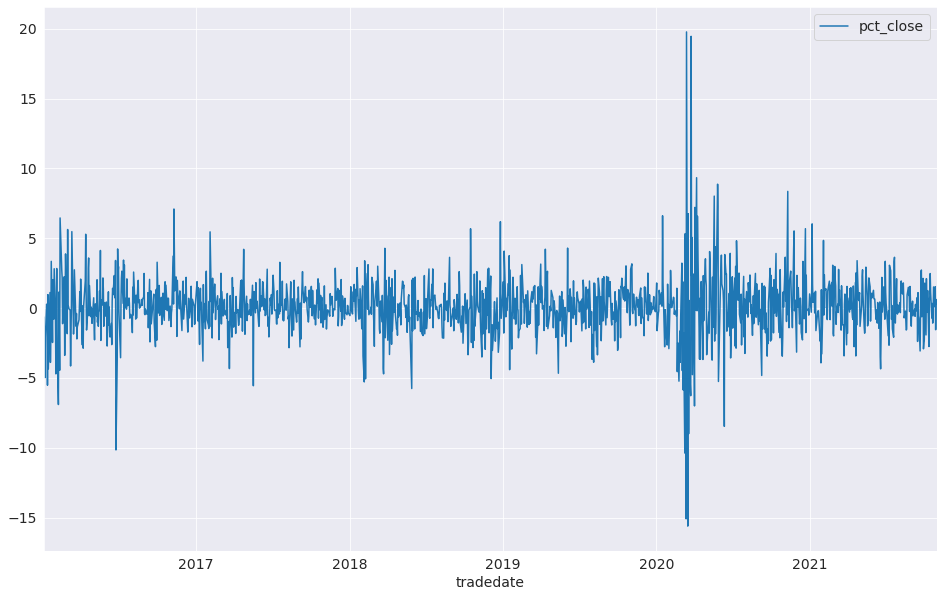

In [4]:
ax = df.plot()
xlim = ax.set_xlim(df.index.min(), df.index.max())


In [5]:
from arch import arch_model

am = arch_model(df, rescale=False, p=1, o=1, q=1, dist="StudentsT")
resg = am.fit(update_freq=5)
print(resg.summary())

Iteration:      5,   Func. Count:     47,   Neg. LLF: 2861.413722974291
Iteration:     10,   Func. Count:     92,   Neg. LLF: 2857.3603280743378
Iteration:     15,   Func. Count:    137,   Neg. LLF: 2856.606913404499
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2856.6065796046096
            Iterations: 18
            Function evaluations: 162
            Gradient evaluations: 18
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                    pct_close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -2856.61
Distribution:      Standardized Student's t   AIC:                           5725.21
Method:                  Maximum Likelihood   BIC:                           5756.95
                                              No. Observation

In [6]:
#fig = res.plot(annualize="D")

In [7]:
from arch.univariate import ARX, HARX, HARCH, GARCH, StudentsT, SkewStudent

am=ARX(df, rescale=False, lags=[1,5,22], constant=True)
am.volatility = GARCH(1,1,1)
am.distribution = StudentsT()
resx = am.fit(update_freq=5)
print(resx.summary())

Iteration:      5,   Func. Count:     68,   Neg. LLF: 2808.964179794869
Iteration:     10,   Func. Count:    130,   Neg. LLF: 2803.6650131457754
Iteration:     15,   Func. Count:    190,   Neg. LLF: 2801.176449835366
Iteration:     20,   Func. Count:    248,   Neg. LLF: 2800.905298395434
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2800.905283282941
            Iterations: 22
            Function evaluations: 270
            Gradient evaluations: 22
                            AR - GJR-GARCH Model Results                            
Dep. Variable:                    pct_close   R-squared:                       0.003
Mean Model:                              AR   Adj. R-squared:                  0.001
Vol Model:                        GJR-GARCH   Log-Likelihood:               -2800.91
Distribution:      Standardized Student's t   AIC:                           5619.81
Method:                  Maximum Likelihood   BIC:                         

In [8]:
am.distribution = SkewStudent()
resk = am.fit(update_freq=5)
print(resk.summary())

Iteration:      5,   Func. Count:     73,   Neg. LLF: 2808.3339834333274
Iteration:     10,   Func. Count:    140,   Neg. LLF: 2803.638680101172
Iteration:     15,   Func. Count:    205,   Neg. LLF: 2801.2075521024717
Iteration:     20,   Func. Count:    270,   Neg. LLF: 2800.8456047839345
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2800.845587613151
            Iterations: 22
            Function evaluations: 294
            Gradient evaluations: 22
                               AR - GJR-GARCH Model Results                              
Dep. Variable:                         pct_close   R-squared:                       0.003
Mean Model:                                   AR   Adj. R-squared:                  0.001
Vol Model:                             GJR-GARCH   Log-Likelihood:               -2800.85
Distribution:      Standardized Skew Student's t   AIC:                           5621.69
Method:                       Maximum Likelihood

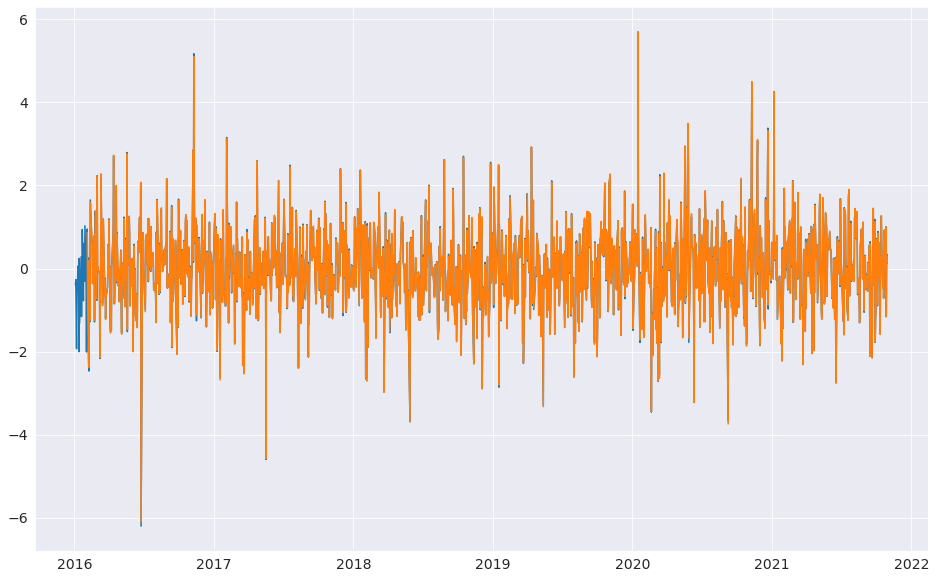

In [9]:
plt.plot(resg.std_resid, label='GJR')
plt.plot(resx.std_resid, label='ARX')

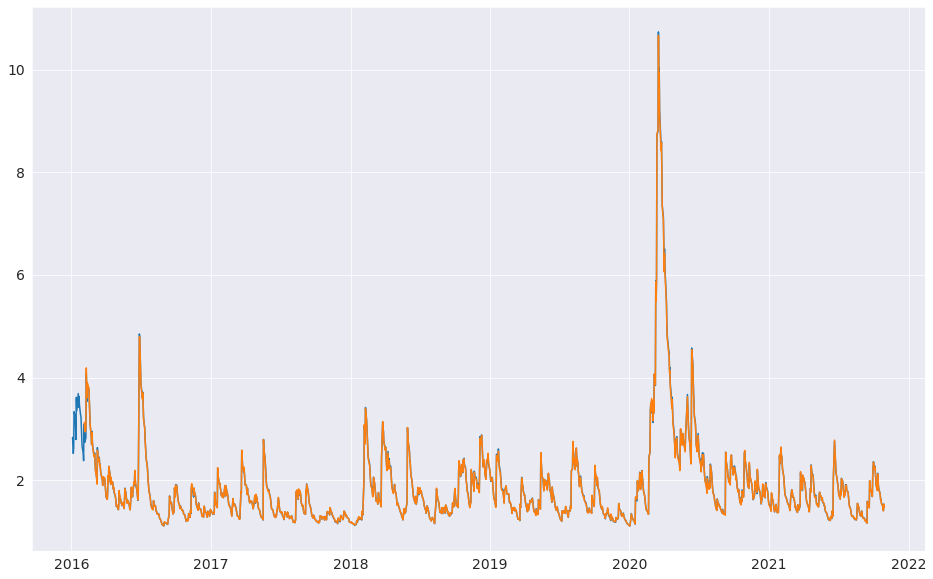

In [10]:
ax = plt.plot(resg.conditional_volatility, label='GJR')
plt.plot(resx.conditional_volatility, label='ARX')

In [11]:
am.volatility = HARCH(lags=[1,5,22])
am.distribution = StudentsT()
res = am.fit(update_freq=5)
print(res.summary())
am.distribution = SkewStudent()
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     69,   Neg. LLF: 2823.3552331492656
Iteration:     10,   Func. Count:    131,   Neg. LLF: 2815.8215765878595
Iteration:     15,   Func. Count:    188,   Neg. LLF: 2815.0499761369088
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2815.049962462093
            Iterations: 16
            Function evaluations: 200
            Gradient evaluations: 16
                              AR - HARCH Model Results                              
Dep. Variable:                    pct_close   R-squared:                       0.007
Mean Model:                              AR   Adj. R-squared:                  0.005
Vol Model:                            HARCH   Log-Likelihood:               -2815.05
Distribution:      Standardized Student's t   AIC:                           5648.10
Method:                  Maximum Likelihood   BIC:                           5695.58
                                              No. Observatio

In [12]:
print("Log-Likelihood = ", resg.loglikelihood, " for GJR")
print("Log-Likelihood = ", resx.loglikelihood, " for ARX")
print("nobs = ", resg.nobs, " for GJR")
print ("nobs = ", resx.nobs, " for ARX")
factor = resg.nobs / resx.nobs
adjusted = resx.loglikelihood * factor
print("Log-Likelihood adjusted = ", adjusted, " for ARX")


Log-Likelihood =  -2856.6065796046096  for GJR
Log-Likelihood =  -2800.905283282941  for ARX
nobs =  1466  for GJR
nobs =  1444  for ARX
Log-Likelihood adjusted =  -2843.578355465922  for ARX
